In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from numpy import sin, cos, tan
from scipy import integrate
from quadcopter_animation import animation

c:\Users\tavar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch.nn as nn
from tqdm import tqdm
from Network_Training import TrajectoryDataset
from normalize import Normalize

# trajectories containing 199 points
dataset_path = 'C:\\Users\\tavar\\Desktop\\Thesis\\Code\\quad_SL\\datasets\\hover_dataset.npz'

dataset = dict()
print('loading dataset...')
with np.load(dataset_path) as full_dataset:
    # total number of trajectories
    num = len(full_dataset['dx'])
    print(num, 'trajectories')
    dataset = {key: full_dataset[key] for key in [
        't', 'dx', 'dy', 'dz', 'vx', 'vy', 'vz', 'phi', 'theta', 'psi', 'p', 'q', 'r','omega', 'u', 'omega_min','omega_max', 'k_omega', 'Mx_ext', 'My_ext', 'Mz_ext'
    ]}
    
train_trajectories = list(set(range(int(0.1*num))) - set(range(int(0.08*num))))

train_indices = [(i, j) for i in train_trajectories for j in range(199)]
train_set = TrajectoryDataset(dataset, train_indices)

X_mean = torch.zeros(19)
X_std = torch.zeros(19)

N=100000

for i, data in tqdm(enumerate(train_set)):
    X = data[0]
    X_mean += X
    if i>=N:
        break
X_mean = X_mean/N

print('mean:')
print(X_mean)
    
for i, data in tqdm(enumerate(train_set)):
    X = data[0]
    X_std += (X-X_mean)**2
    if i>=N:
        break

X_std = torch.sqrt(X_std/N)
print('std:')
print(X_std)

model = nn.Sequential(
    Normalize(mean=X_mean, std=X_std),
    nn.Linear(19, 120),
    nn.ReLU(),
    nn.Linear(120, 120),
    nn.ReLU(),
    nn.Linear(120, 120),
    nn.ReLU(),
    nn.Linear(120, 4),
    nn.Sigmoid()
)

model.load_state_dict(torch.load('neural_networks/model_whole_dataset.pth'))
model.eval()

for p in model.parameters():
    p.requires_grad = False

loading dataset...
100000 trajectories


100000it [00:03, 29589.51it/s]


mean:
tensor([-3.9669e-02,  2.6970e-02, -6.4284e-01, -7.4736e-02,  2.1193e-03,
        -1.3984e-01,  4.2224e-03,  7.2879e-04,  2.4172e-02,  7.9308e-03,
        -2.0619e-02, -3.5359e-02,  7.7542e+03,  7.6897e+03,  7.7257e+03,
         7.6425e+03,  4.9821e-04, -4.1630e-04,  2.8531e-04])


100000it [00:05, 18245.72it/s]
c:\Users\tavar\Desktop\Thesis\Code\quad_SL\normalize.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean, dtype=torch.float32)
c:\Users\tavar\Desktop\Thesis\Code\quad_SL\normalize.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std, dtype=torch.float32)


std:
tensor([1.5888e+00, 1.6326e+00, 1.0490e+00, 1.5353e+00, 1.6638e+00, 6.2538e-01,
        3.1185e-01, 2.9286e-01, 1.0005e+00, 1.5471e+00, 1.3706e+00, 1.1060e+00,
        9.7113e+02, 9.6977e+02, 9.9825e+02, 9.5903e+02, 2.3120e-02, 2.3222e-02,
        5.8394e-03])


In [4]:
def neural_network(X):
    with torch.no_grad():
        X = list(X[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]])
        u = model(torch.tensor(X, dtype=torch.float32)).detach().numpy()
        return u

neural_network(np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]))

array([0., 0., 1., 0.], dtype=float32)

In [5]:
def transform(X):
    # TRANSFORM COORDINATES TO BODY FRAME
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r, utau1, utau2, utau3, utau4, Mx, My, Mz = X
    Rx = np.array([[1, 0, 0], [0, np.cos(phi), -np.sin(phi)], [0, np.sin(phi), np.cos(phi)]])
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
    Rz = np.array([[np.cos(psi), -np.sin(psi), 0], [np.sin(psi), np.cos(psi), 0], [0, 0, 1]])
    R = Rz@Ry@Rx
    
    # new state variables
    xn, yn, zn = -R.T@[x,y,z]
    vxn, vyn, vzn = R.T@[vx,vy,vz]
    
    Xn = np.array([xn, yn, zn, vxn, vyn, vzn, phi, theta, psi, p, q, r, utau1, utau2, utau3, utau4, Mx, My, Mz])
    return Xn

def transform_back(X):
    # TRANSFORM COORDINATES TO WORLD FRAME
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r, utau1, utau2, utau3, utau4, Mx, My, Mz = X
    Rx = np.array([[1, 0, 0], [0, np.cos(phi), -np.sin(phi)], [0, np.sin(phi), np.cos(phi)]])
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
    Rz = np.array([[np.cos(psi), -np.sin(psi), 0], [np.sin(psi), np.cos(psi), 0], [0, 0, 1]])
    R = Rz@Ry@Rx
    
    # new state variables
    xn, yn, zn = -R@[x,y,z]
    vxn, vyn, vzn = R@[vx,vy,vz]
    
    Xn = np.array([xn, yn, zn, vxn, vyn, vzn, phi, theta, psi, p, q, r, utau1, utau2, utau3, utau4, Mx, My, Mz])
    return Xn

In [6]:
# trajectory dataset
dataset_path = 'C:\\Users\\tavar\\Desktop\\Thesis\\Code\\quad_SL\\datasets\\hover_dataset.npz'
dataset = np.load(dataset_path)

g         = dataset['g']
mass      = dataset['mass']
Ixx       = dataset['Ixx']
Iyy       = dataset['Iyy']
Izz       = dataset['Izz']

k_x       = dataset['k_x']
k_y       = dataset['k_y']
k_z       = dataset['k_z']
k_omega   = dataset['k_omega']
k_h       = dataset['k_h']
k_p       = dataset['k_p']
k_pv      = dataset['k_pv']
k_q       = dataset['k_q']
k_qv      = dataset['k_qv']
k_r1      = dataset['k_r1']
k_r2      = dataset['k_r2']
k_rr      = dataset['k_rr']

omega_max = dataset['omega_max']
omega_min = dataset['omega_min']
tau       = dataset['tau']

print(omega_min, omega_max)
print(dataset['dx'].shape)
print(tau)

print(g, Ixx, Iyy, Izz, k_x, k_y, k_z, k_omega, k_h, k_p, k_pv, k_q, k_qv, k_r1, k_r2, k_rr, tau, sep=',')

5000.0 10000.0
(100000, 199)
0.06
9.81,0.000906,0.001242,0.002054,1.07933887e-05,9.65250793e-06,2.7862899e-05,4.36301076e-08,0.0625501332,1.4119331e-09,-0.00797101848,1.21601884e-09,0.0129263739,2.57035545e-06,4.10923364e-07,0.000812932607,0.06


In [19]:
Mx, My, Mz = 0, 0, 0

In [8]:
def dynamics(t, y, u):    
    # state
    dx, dy, dz, vx, vy, vz, phi, theta, psi, p, q, r, omega1, omega2, omega3, omega4, Mx, My, Mz = y
    
    # control input
    u1, u2, u3, u4 = u
    
    d_dx    = -q*dz + r*dy - vx
    d_dy    =  p*dz - r*dx - vy
    d_dz    = -p*dy + q*dx - vz
    
    omegas = omega1 + omega2 + omega3 + omega4
    omegas2 = omega1**2 + omega2**2 + omega3**2 + omega4**2
    
    d_vx    = -q*vz + r*vy - g*sin(theta) - k_x*omegas*vx
    d_vy    =  p*vz - r*vx + g*cos(theta)*sin(phi) - k_y*omegas*vy
    d_vz    = -p*vy + q*vx + g*cos(theta)*cos(phi) - k_z*omegas*vz - k_omega*omegas2 - k_h*(vx**2+vy**2)
    
    d_phi   = p + q*sin(phi)*tan(theta) + r*cos(phi)*tan(theta)
    d_theta = q*cos(phi) - r*sin(phi)
    d_psi   = q*sin(phi)/cos(theta) + r*cos(phi)/cos(theta)
    
    d_omega1 = (omega_min + u1*(omega_max - omega_min)-omega1)/tau
    d_omega2 = (omega_min + u2*(omega_max - omega_min)-omega2)/tau
    d_omega3 = (omega_min + u3*(omega_max - omega_min)-omega3)/tau
    d_omega4 = (omega_min + u4*(omega_max - omega_min)-omega4)/tau
    
    taux = k_p*(omega1**2-omega2**2-omega3**2+omega4**2) + k_pv*vy + Mx
    tauy = k_q*(omega1**2+omega2**2-omega3**2-omega4**2) + k_qv*vx + My
    tauz = k_r1*(-omega1+omega2-omega3+omega4) + k_r2*(-d_omega1+d_omega2-d_omega3+d_omega4) - k_rr*r + Mz
    
    d_p     = (q*r*(Iyy-Izz) + taux)/Ixx
    d_q     = (p*r*(Izz-Ixx) + tauy)/Iyy
    d_r     = (p*q*(Ixx-Iyy) + tauz)/Izz
    
    return np.array([d_dx, d_dy, d_dz, d_vx, d_vy, d_vz, d_phi, d_theta, d_psi, d_p, d_q, d_r, d_omega1, d_omega2, d_omega3, d_omega4, Mx, My, Mz]) 

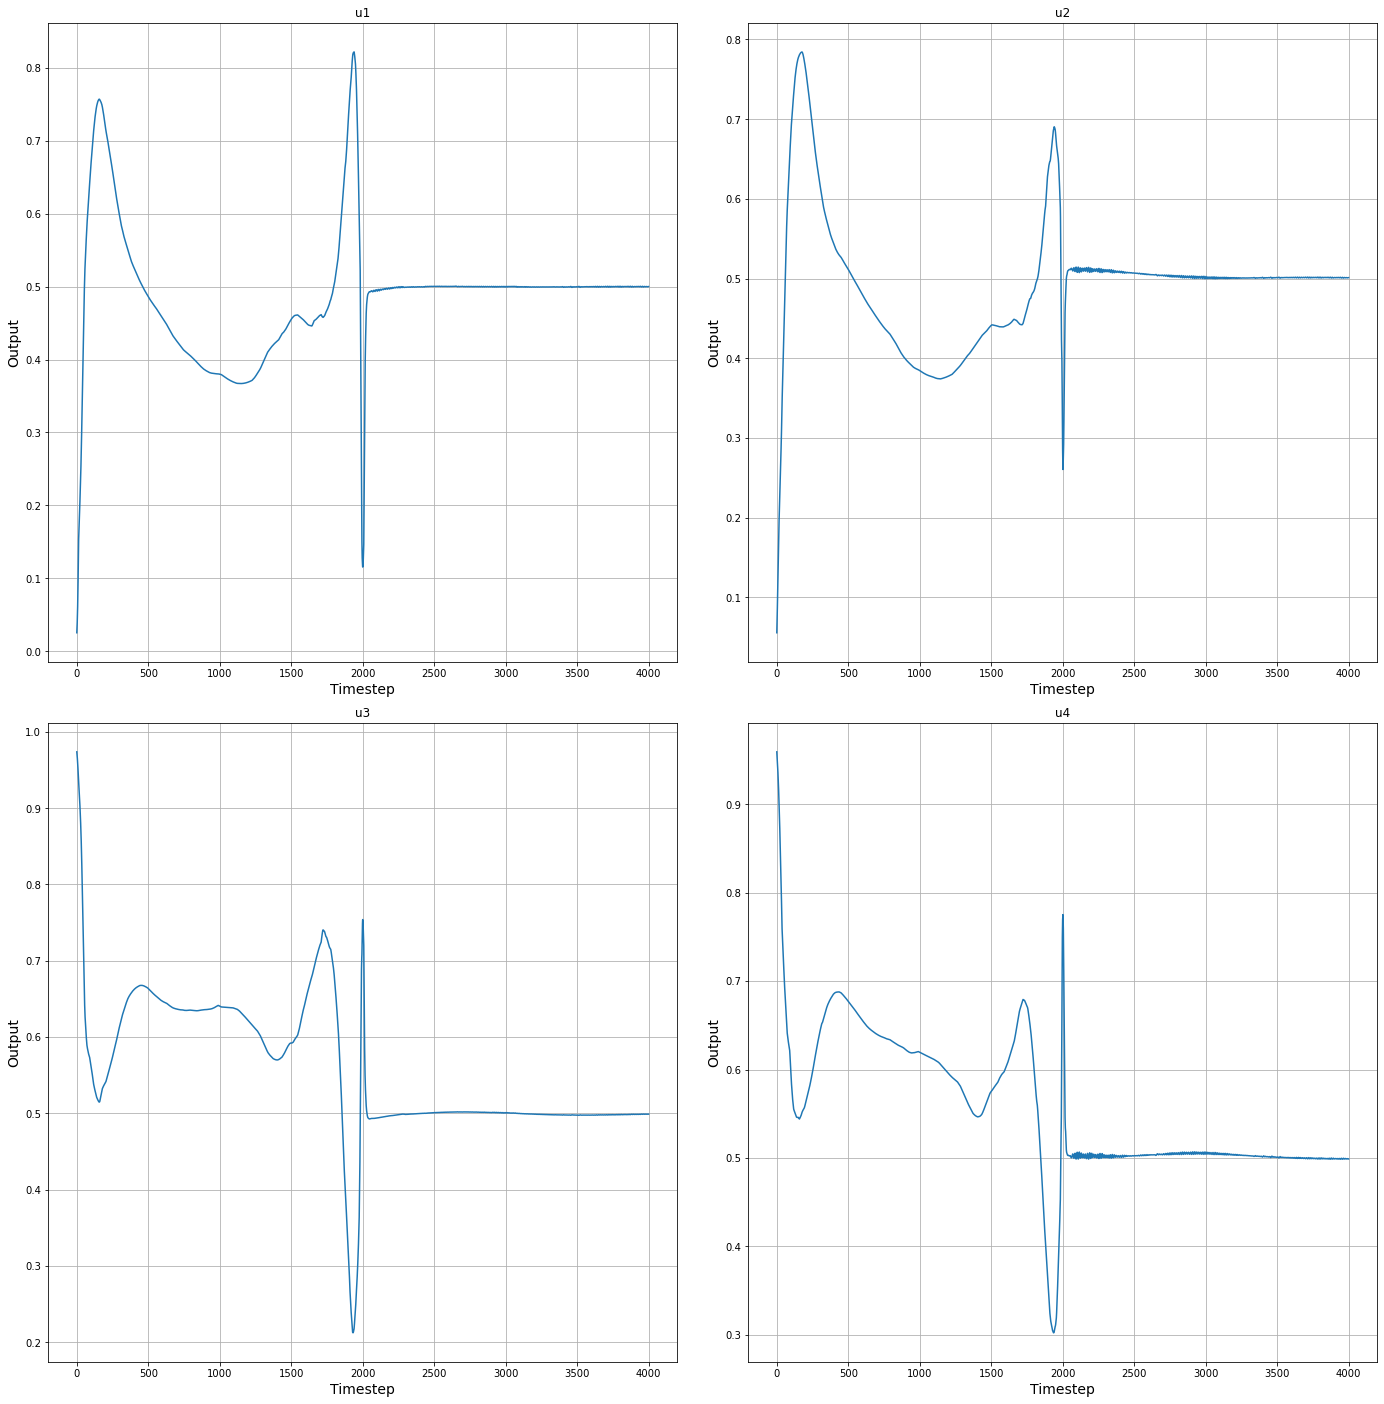

In [20]:
##### longer time
t = np.linspace(0,20,20000)

y_0= np.zeros(19)
y_0[12:16] = (omega_max+omega_min)/2
y_0[0] = 4.
y_0[1] = 0.
y_0[8] = 0.*np.pi/2
y_0[16] = Mx
y_0[17] = My
y_0[18] = Mz

def dydt(t, y):
    dx, dy, dz, vx, vy, vz, phi, theta, psi, p, q, r, omega1, omega2, omega3, omega4, Mx, My, Mz = y
    u = neural_network(y)
    return dynamics(t, y, u)

sol = integrate.solve_ivp(dydt, (0, 20), y_0, t_eval=t)

y_sim = sol.y.T
y_sim_w = np.array([transform_back(yi) for yi in y_sim])

x, y, z, vx, vy, vz, phi, theta, psi, p, q, r, omega1, omega2, omega3, omega4, Mx, My, Mz = y_sim_w.T
u = np.array([neural_network(yi) for yi in y_sim])
# print(u)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
fig.tight_layout(pad=4.0)
labels_output = ["u1", "u2", "u3", "u4"]
# fig.suptitle("Input parameters", fontsize=18)
for i, ax in enumerate(axes.flat):
    ax.plot(u[0: 4000, i], label='Estimated')
    ax.set_xlabel('Timestep', fontdict={"size":14})
    ax.set_ylabel('Output', fontdict={"size":14})
    ax.grid(True)
    ax.set_title(labels_output[i])


In [21]:
animation.animate(t,x,y,z-1,phi,theta,psi,u, waypoints=[np.array([0.,0.,-1.]), np.array([-4.,0.,-1.])])

# Flying a continuous trajectory

In [11]:
from quadcopter_animation import animation
import scipy.interpolate


target1 = np.array([-2.,-2.,-1.])
target2 = np.array([ 2.,-2.,-1.])
target3 = np.array([ 2., 2.,-1.])
target4 = np.array([-2., 2.,-1.])
Mx, My, Mz = 0, 0, 0

target = target2

t = np.linspace(0, 10, 1000)
t0 = 0

y0_w = np.zeros(19)
y0_w[0:3] = target1
y0_w[12:16] = (dataset["omega_max"] + dataset["omega_min"])/2
y0_w[16] = Mx
y0_w[17] = My
y0_w[18] = Mz


y0 = transform(y0_w)

psi_ref = 0
u_list = []
target_list = []


def dydt(t, y):
    global target, psi_ref, u_list, t0
    # state in world coordinates
    y_w = transform_back(y)
    
    delta_pos = y_w[0:3] - target
    if target is target2:
        psi_ref = 0
        normal = np.array([np.cos(np.pi*1/4), np.sin(np.pi*1/4), 0.])
        if np.linalg.norm(delta_pos) < 0.8:
            target = target3
    elif target is target3:
        psi_ref = np.pi/2
        normal = np.array([np.cos(np.pi*3/4), np.sin(np.pi*3/4), 0.])
        if np.linalg.norm(delta_pos) < 0.8:
            target = target4
    elif target is target4:
        psi_ref = np.pi
        normal = np.array([np.cos(np.pi*5/4), np.sin(np.pi*5/4), 0.])
        if np.linalg.norm(delta_pos) < 0.8:
            target = target1
    elif target is target1:
        psi_ref = -np.pi/2
        normal = np.array([np.cos(np.pi*7/4), np.sin(np.pi*7/4), 0.])
        if np.linalg.norm(delta_pos) < 0.8:
            target = target2
    
           
    
    # describe state relative to target
    y_w[0:3] -= target
    
    nn_input = transform(y_w)
    
    nn_input[8] -= psi_ref
    
    while nn_input[8] > np.pi:
        nn_input[8] -= np.pi*2
    while nn_input[8] < -np.pi:
        nn_input[8] += np.pi*2
    
    
    # control input
    u = neural_network(nn_input) #,Mx,My,Mz)
    u_list.append((t, u))
    target_list.append((t, target))
    
    d_y = dynamics(t, y, u)
    return d_y
    

sol = integrate.solve_ivp(dydt, (t[0], t[-1]), y0, t_eval=t)
y_sim = sol.y.T
y_sim_w = np.array([transform_back(yi) for yi in y_sim])

x, y, z, vx, vy, vz, phi, theta, psi = y_sim_w[:, 0:9].T

t_ = np.array([ti for ti, ui in u_list])
u_ = np.array([ui for ti, ui in u_list])
u_ = scipy.interpolate.interp1d(t_, u_, axis=0, fill_value="extrapolate")
u_ = u_(t)

t_ = np.array([ti for ti, targeti in target_list])
target_ = np.array([targeti for ti, targeti in target_list])
target_ = scipy.interpolate.interp1d(t_, target_, axis=0, fill_value="extrapolate")
target_ = target_(t)

animation.animate(t,x,y,z,phi,theta,psi,u_, target=target_, waypoints=[target1,target2,target3,target4])

In [12]:
import matplotlib.cm as cm
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=0, vmax=6)
cmap = cm.jet

def color_plot(x_axis, y_axis):
    step = 10
    for i in reversed(range(step,len(x_axis),step)):
        ax = plt.gca()
        ax.plot([x_axis[i-step], x_axis[i]], [y_axis[i-step], y_axis[i]])

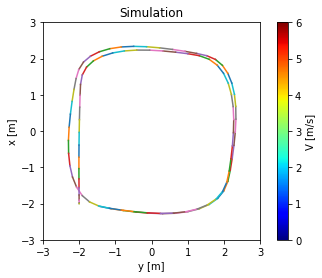

In [13]:
color_plot(y,x)
plt.xlabel('y [m]')
plt.ylabel('x [m]')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='V [m/s]')
plt.title('Simulation')
plt.show()